<a href="https://colab.research.google.com/github/iasolb/ECON3916-Statistics-MachineLearning/blob/main/Lab7/Lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Lab 7 ] Estimation — From Formulas to Bootstrapping

Ian Solberg

Feb 2026

Professor Piao

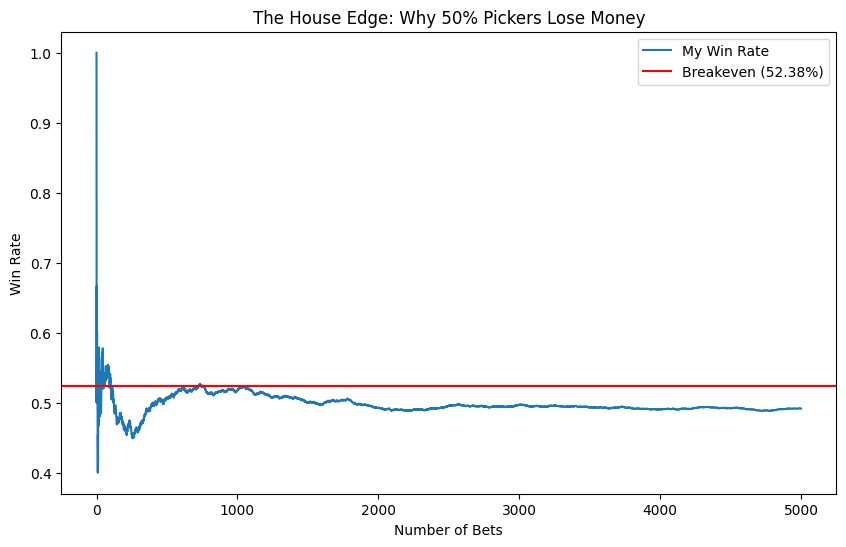

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup
true_skill = 0.50       # You win 50% of the time
breakeven = 0.5238      # -110 odds requires 52.38% to profit
n_bets = 5000           # Simulating a full season

# 2. Simulate
outcomes = np.random.binomial(1, true_skill, size=n_bets)   # 1=win, 0=loss
cumulative_win_rate = np.cumsum(outcomes) / np.arange(1, n_bets + 1)

# 3. Plot
plt.figure(figsize=(10,6))
plt.plot(cumulative_win_rate, label="My Win Rate")
plt.axhline(breakeven, color='red', label="Breakeven (52.38%)")
plt.legend()
plt.title("The House Edge: Why 50% Pickers Lose Money")
plt.xlabel("Number of Bets")
plt.ylabel("Win Rate")
plt.show()

Sampling Error Audit:
Sample 1: Mean = 42.00% | Error = +6.73%
Sample 2: Mean = 36.00% | Error = +0.73%
Sample 3: Mean = 42.00% | Error = +6.73%


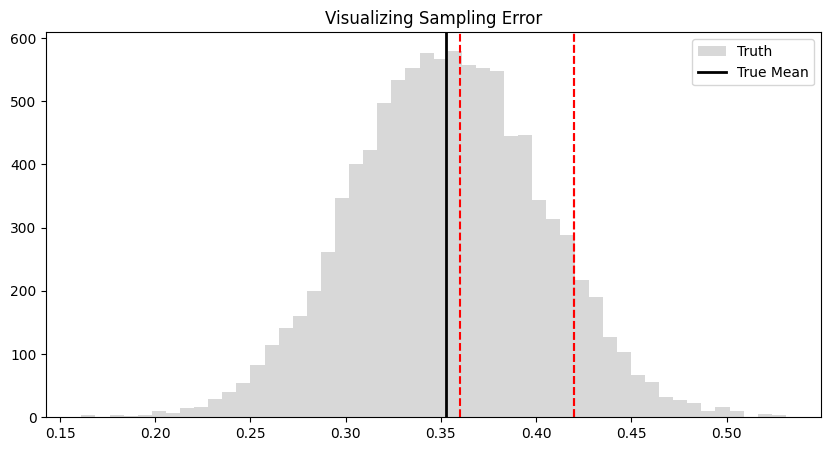

In [ ]:
# 1. The "Unknown" Truth
true_mu = 0.3527  # Matching the "True Population Mean"

# 2. Simulate 3 distinct "Samples" (e.g., 3 different users)
samples = []
print(f"Sampling Error Audit:")

for i in range(3):
    # Draw 50 random bets
    sample = np.random.binomial(1, true_mu, size=50)

    # Calculate stats
    x_bar = sample.mean()
    error = x_bar - true_mu   # The Formula: Error = x_bar - mu

    print(f"Sample {i+1}: Mean = {x_bar:.2%} | Error = {error:+.2%}")
    samples.append(x_bar)

# 3. Quick Visual Check
plt.figure(figsize=(10,5))
plt.hist(np.random.normal(true_mu, 0.05, 10000), bins=50, alpha=0.3, color='gray', label='Truth')
for mean in samples:
    plt.axvline(mean, color='red', linestyle='--') # Our Samples
plt.axvline(true_mu, color='black', linewidth=2, label='True Mean')
plt.title("Visualizing Sampling Error")
plt.legend()
plt.show()

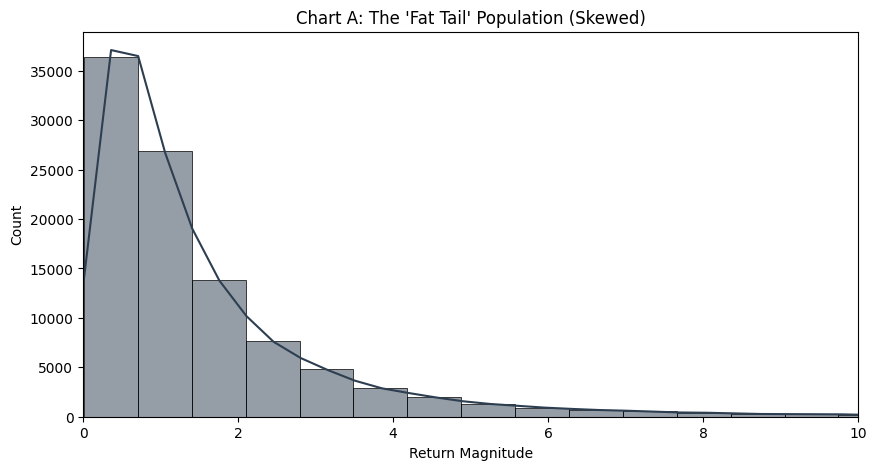

In [ ]:
import seaborn as sns

# 1. Define the "Crypto Universe" (Population)
# Log-Normal matches the skewed "Hump + Long Tail" shape of markets
population_data = np.random.lognormal(mean=0, sigma=1.0, size=100000)

# 2. Visualize the Chaos
plt.figure(figsize=(10, 5))
sns.histplot(population_data, bins=100, kde=True, color='#2c3e50')
plt.xlim(0, 10)  # Crop to see the shape clearly
plt.title("Chart A: The 'Fat Tail' Population (Skewed)")
plt.xlabel("Return Magnitude")
plt.show()

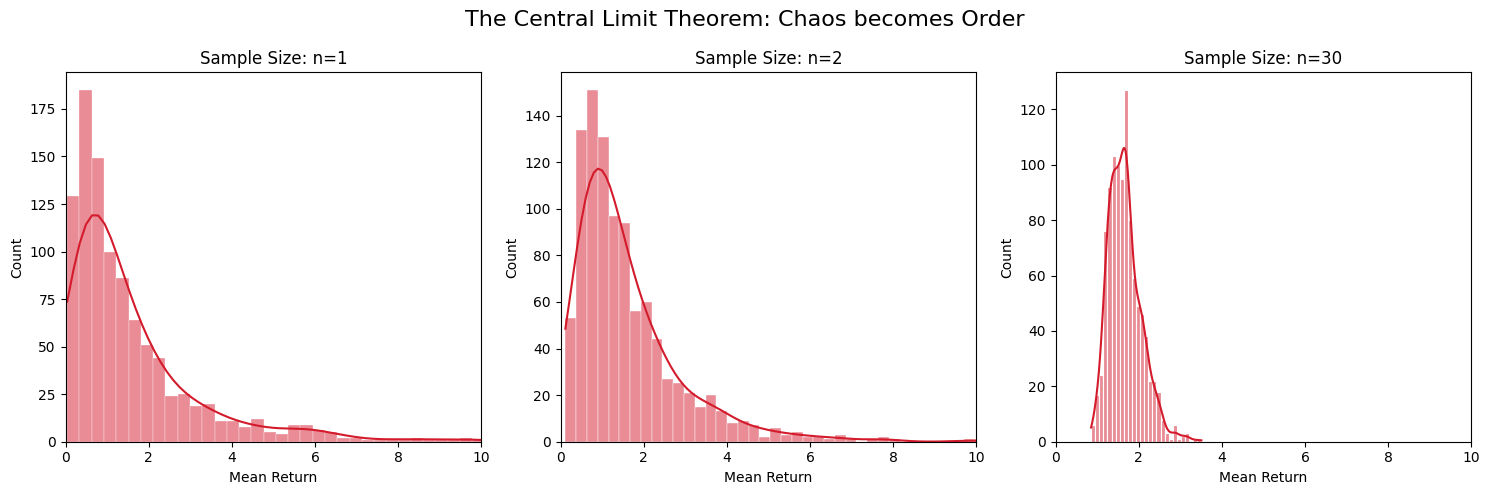

In [ ]:
# Setup: Compare 3 sample sizes to match the slide
sample_sizes = [1, 2, 30]
simulations = 1000

plt.figure(figsize=(15, 5))

for i, n in enumerate(sample_sizes):
    # 1. The Loop: Calculate 1000 averages
    means = []
    for _ in range(simulations):
        sample = np.random.choice(population_data, size=n)
        means.append(np.mean(sample))

    # 2. Plotting
    plt.subplot(1, 3, i+1)
    sns.histplot(means, kde=True, color='#d41b2c', edgecolor='white')
    plt.title(f"Sample Size: n={n}")
    plt.xlabel("Mean Return")
    plt.xlim(0, 10)

plt.suptitle("The Central Limit Theorem: Chaos becomes Order", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# 1. Setup: Two Populations, same variance, vastly different sizes
std_dev = 15000  # Variation in spending
n = 100          # We only sample 100 users (The "Teaspoon")

# 2. Calculate Margin of Error (1.96 * sigma / sqrt(n))
# Notice: Big 'N' (Population Size) is NOT in this formula!
margin_error = 1.96 * std_dev / np.sqrt(n)

# 3. Print Results

print(f"--- The Soup Analogy ---")
print(f"Population: 1,000 users   | Margin of Error: ±${margin_error:,.2f}")
print(f"Population: 1,000,000 users | Margin of Error: ±${margin_error:,.2f}")
print(f"Conclusion: The pot size doesn't matter. Only the spoon size (n) matters.")

--- The Soup Analogy ---
Population: 1,000 users   | Margin of Error: ±$2,940.00
Population: 1,000,000 users | Margin of Error: ±$2,940.00
Conclusion: The pot size doesn't matter. Only the spoon size (n) matters.


In [ ]:
# Metric: LTV/CAC Ratio (Target > 3.0)
mean_val = 4.0
n_samples = 50

# Compare Stable (A) vs Volatile (B) Companies
sigma_A = 0.5  # Stable
sigma_B = 6.0  # Volatile

moe_A = np.sqrt(sigma_A**2 / n_samples)
moe_B = np.sqrt(sigma_B**2 / n_samples)


print("\n--- VC Audit: Series C Benchmark (> 3.0) ---")

print(f"Startup A (Stable):")
print(f"   95% CI: [{mean_val - moe_A:.1f}, {mean_val + moe_A:.1f}]")
print(f"   Decision: INVEST. (Lower bound > 3.0)")

print(f"\nStartup B (Volatile):")
print(f"   95% CI: [{mean_val - moe_B:.1f}, {mean_val + moe_B:.1f}]")
print(f"   Decision: PASS. (Lower bound implies potential loss)")


--- VC Audit: Series C Benchmark (> 3.0) ---
Startup A (Stable):
   95% CI: [3.9, 4.1]
   Decision: INVEST. (Lower bound > 3.0)

Startup B (Volatile):
   95% CI: [3.2, 4.8]
   Decision: PASS. (Lower bound implies potential loss)


## Naive Code

In [ ]:
import numpy as np

# BASE CASE: Independence Assumption (The "Naive" Model)
n_simulations = 1000
months = 24
start_cash = 2_000_000
bankruptcies = 0

print("Running Base Model (Independence)...")

for _ in range(n_simulations):
    cash = start_cash
    alive = True

    for month in range(months):
        # SIMULATION LOGIC:
        # Revenue: Average $80k, swings wildly (StdDev $30k)
        # Burn: Average $100k, fairly fixed (StdDev $10k)
        # INDEPENDENT: Bad revenue months don't automatically trigger cost cuts.

        revenue = np.random.normal(80000, 30000)
        burn = np.random.normal(100000, 10000)

        # Net Flow
        cash += (revenue - burn)

        if cash <= 0:
            alive = False
            break

    if not alive:
        bankruptcies += 1

prob_ruin = bankruptcies / n_simulations
print(f"Base Model Risk of Ruin: {prob_ruin:.1%}")
print("Critique: This assumes if Revenue crashes, Management keeps spending money. Unrealistic.")

Running Base Model (Independence)...
Base Model Risk of Ruin: 0.0%
Critique: This assumes if Revenue crashes, Management keeps spending money. Unrealistic.


## Prime Code

In [ ]:
import numpy as np

# CORRELATED MODEL: Revenue and Burn move together (rho = 0.7)
n_simulations = 1000
months = 24
start_cash = 2_000_000
bankruptcies = 0

# --- Distribution Parameters ---
mean_revenue = 80_000
mean_burn    = 100_000
std_revenue  = 30_000
std_burn     = 10_000
rho          = 0.7  # Correlation coefficient

# --- Covariance Matrix ---
# Cov(X,Y) = rho * std_X * std_Y
cov_rv_burn = rho * std_revenue * std_burn          # 210,000

cov_matrix = [
    [std_revenue**2, cov_rv_burn],   # Var(Revenue),  Cov(Rev, Burn)
    [cov_rv_burn,    std_burn**2 ],  # Cov(Rev, Burn), Var(Burn)
]

means = [mean_revenue, mean_burn]

print("Running Correlated Model (rho=0.7)...")

for _ in range(n_simulations):
    cash = start_cash
    alive = True

    # Draw all 24 monthly pairs at once — more efficient than looping
    monthly_draws = np.random.multivariate_normal(means, cov_matrix, size=months)
    # Shape: (24, 2) → column 0 = revenue, column 1 = burn

    for month in range(months):
        revenue = monthly_draws[month, 0]
        burn    = monthly_draws[month, 1]

        cash += (revenue - burn)

        if cash <= 0:
            alive = False
            break

    if not alive:
        bankruptcies += 1

prob_ruin = bankruptcies / n_simulations
print(f"Correlated Model Risk of Ruin: {prob_ruin:.1%}")
print(
    "Note: rho=0.7 means when Revenue is low, Burn tends to be low too.\n"
    "This models management cutting costs when revenue drops — more realistic."
)

Running Correlated Model (rho=0.7)...
Correlated Model Risk of Ruin: 0.0%
Note: rho=0.7 means when Revenue is low, Burn tends to be low too.
This models management cutting costs when revenue drops — more realistic.


## Model Response (Sonnet 4.6)


It lowers the probability of ruin. Here's why:
The mechanics of the correlation With rho=0.7, revenue and burn move in the same direction together. When revenue takes a bad draw (say, $40k instead of $80k), burn is statistically likely to also take a low draw (say, $88k instead of $100k). The net cash flow in that bad month is less catastrophic than if burn had stayed at its average.

In the independent model, burn doesn't "know" that revenue just crashed — it keeps drawing near $100k regardless. That's the worst-case combination: low revenue and full burn hitting simultaneously with no relationship between them.
The core intuition: you're reducing the variance of net cash flow

What actually drives ruin is the variance of (Revenue - Burn), not the variance of each individually. The formula for that variance is:

$$Var(Rev - Burn) = Var(Rev) + Var(Burn) - 2·Cov(Rev, Burn)$$
```
Plugging in the numbers:
```
$$
Independent:  900,000,000 + 100,000,000 - 2·(0)       = 1,000,000,000 $$

$$Correlated:   900,000,000 + 100,000,000 - 2·(210,000) =   579,580,000
$$

-  much tighter

The correlated model has 42% less variance in monthly net flow. Tighter net flow variance means fewer extreme negative months, which is precisely what drains the cash reserve to zero.

The modeling interpretation

The correlation is implicitly encoding a management response when revenue drops, costs get cut. That's a realistic and stabilizing dynamic. The independent model assumes a company that keeps burning cash at full speed no matter how bad revenue gets, which is a much more dangerous firm to model.

The one caveat If rho were negative (revenue up when burn is up — say, a sales team that spends aggressively in good months), ruin probability would increase because you'd be adding variance to net flow rather than subtracting it. The sign of the correlation matters as much as the magnitude.